<a href="https://colab.research.google.com/github/donaldziff/kgqa-ucb-210/blob/main/Experimental_Text_Generation_with_T5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing the required packages

In [4]:
!pip install transformers
!pip install sentencepiece
import pandas as pd
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
warnings.filterwarnings('ignore')
from huggingface_hub import notebook_login

notebook_login()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 113.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.5 MB/s eta 0:00:00


## Importing required libraries

In [5]:
import pandas as pd
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
warnings.filterwarnings('ignore')

In [6]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


#Log into hugging face

## Preprocess the data

In [7]:
import urllib.request
import zipfile
url = 'https://gitlab.com/shimorina/webnlg-dataset/-/archive/master/webnlg-dataset-master.zip?path=release_v3.0/en/train'
urllib.request.urlretrieve(url, 'web.zip')
with zipfile.ZipFile('web.zip', 'r') as zip_ref:
    zip_ref.extractall('web')
import glob
import os
import re
import xml.etree.ElementTree as ET
import pandas as pd
files = glob.glob("/content/web/webnlg-dataset-master-release_v3.0-en-train/release_v3.0/en/train/**/*.xml", recursive=True)
triple_re=re.compile('(\d)triples')
data_dct={}
for file in files:
    tree = ET.parse(file)
    root = tree.getroot()
    triples_num=int(triple_re.findall(file)[0])
    for sub_root in root:
        for ss_root in sub_root:
            strutured_master=[]
            unstructured=[]
            for entry in ss_root:
                unstructured.append(entry.text)
                strutured=[triple.text for triple in entry]
                strutured_master.extend(strutured)
            unstructured=[i for i in unstructured if i.replace('\n','').strip()!='' ]
            strutured_master=strutured_master[-triples_num:]
            strutured_master_str=(' && ').join(strutured_master)
            data_dct[strutured_master_str]=unstructured
mdata_dct={"prefix":[], "input_text":[], "target_text":[]}
for st,unst in data_dct.items():
    for i in unst:
        mdata_dct['prefix'].append('webNLG')
        mdata_dct['input_text'].append(st)
        mdata_dct['target_text'].append(i)


df=pd.DataFrame(mdata_dct)
df.to_csv('webNLG2020_train.csv')

In [8]:
train_df=pd.read_csv('webNLG2020_train.csv', index_col=[0])

In [9]:
train_df

,prefix,input_text,target_text
0,webNLG,AWH_Engineering_College | country | India && A...,The River Ganges flows through India which is ...
1,webNLG,AWH_Engineering_College | country | India && A...,The AWH Engineering College is located in Kutt...
2,webNLG,AWH_Engineering_College | country | India && A...,"The AWH Engineering College, Kuttikkattoor, Ke..."
3,webNLG,AWH_Engineering_College | country | India && A...,The leader of Kerala is Kochi and the state li...
4,webNLG,AWH_Engineering_College | country | India && A...,The AWH Engineering College is located in Kutt...
...,...,...,...
35202,webNLG,Trane | product | Building_Management_System &...,Trane is a subsidiary company founded in Sword...
35203,webNLG,Trane | product | Building_Management_System &...,"Trane, a manufacturer of building management s..."
35204,webNLG,Trane | product | Building_Management_System &...,Trane is a producer of building management sys...
35205,webNLG,Trane | product | Building_Management_System &...,"Located in Swords, Dublin, Trane is a subsidia..."


Trimming off a few data points and so that a batch would not leave any remainder, hence some lines of codes can be avoided (Okay, this might be a hackish way of doing it )

In [10]:
train_df=train_df.iloc[  :35000,:]

In [11]:
train_df=train_df.sample(frac = 1)

In [12]:
batch_size=8
num_of_batches=len(train_df)/batch_size
num_of_epochs=4

In [13]:
num_of_batches=int(num_of_batches)

Checking for the GPU availability

In [14]:
if torch.cuda.is_available():
    dev = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


## Loading the pretrained model and tokenizer

In [15]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
#moving the model to device(GPU/CPU)
model.to(dev)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

## Initializing the Adafactor optimizer with parameter values suggested for t5

In [16]:

optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

  






In [17]:

from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

In [14]:
num_of_epochs=1

## Training the model

In [18]:
#Sets the module in training mode
model.train()

loss_per_10_steps=[]
for epoch in range(1,num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))
  
  running_loss=0

  out = display(progress(1, num_of_batches+1), display_id=True)
  for i in range(num_of_batches):
    inputbatch=[]
    labelbatch=[]
    new_df=train_df[i*batch_size:i*batch_size+batch_size]
    for indx,row in new_df.iterrows():
      input = 'WebNLG: '+row['input_text']+'</s>' 
      labels = row['target_text']+'</s>'   
      inputbatch.append(input)
      labelbatch.append(labels)
    inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=400,return_tensors='pt')["input_ids"]
    labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,max_length=400,return_tensors="pt") ["input_ids"]
    inputbatch=inputbatch.to(dev)
    labelbatch=labelbatch.to(dev)

    # clear out the gradients of all Variables 
    optimizer.zero_grad()

    # Forward propogation
    outputs = model(input_ids=inputbatch, labels=labelbatch)
    loss = outputs.loss
    loss_num=loss.item()
    logits = outputs.logits
    running_loss+=loss_num
    if i%10 ==0:      
      loss_per_10_steps.append(loss_num)
    out.update(progress(loss_num,i, num_of_batches+1))

    # calculating the gradients
    loss.backward()

    #updating the params
    optimizer.step()
    
  running_loss=running_loss/int(num_of_batches)
  print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))
  

Running epoch: 1


Epoch: 1 , Running loss: 0.49806906503438947
Running epoch: 2


Epoch: 2 , Running loss: 0.37688777917282923
Running epoch: 3


KeyboardInterrupt: ignored

## Plotting the loss over time

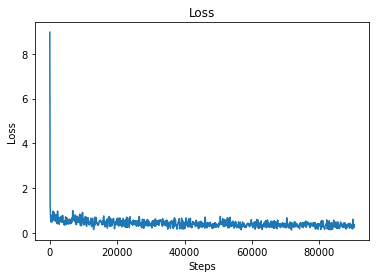

In [19]:
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

## Testing the model

In [20]:
model.eval()
input_ids = tokenizer.encode("WebNLG: sidharth | hometown | Delhi && sidharth | play |  football </s>", return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
tokenizer.decode(outputs[0])

'<pad>Sidharth, a footballer, is a player in the city of Delhi'

Before testing the model further, lets learn how to serialize it and load from the path

#Push to huggingface

### We can figure out project and organization of models later on

In [24]:
#model.push_to_hub(repo_name="shrinivasbjoshi/w210AskWiki")

model.push_to_hub(repo_url="https://huggingface.co/shrinivasbjoshi/w210AskWiki",repo_id="shrinivasbjoshi/w210AskWiki")

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/shrinivasbjoshi/w210AskWiki/commit/0eccdc4c9e9a14abab6b0b1fd9e68d67e0a1d3a7', commit_message='Upload T5ForConditionalGeneration', commit_description='', oid='0eccdc4c9e9a14abab6b0b1fd9e68d67e0a1d3a7', pr_url=None, pr_revision=None, pr_num=None)

In [25]:
model.push_to_hub("W210T5NLG")

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/shrinivasbjoshi/W210T5NLG/commit/f557d1bd2e5c78a51653645b0676ce74a7b07586', commit_message='Upload T5ForConditionalGeneration', commit_description='', oid='f557d1bd2e5c78a51653645b0676ce74a7b07586', pr_url=None, pr_revision=None, pr_num=None)

##W210 Testing

In [26]:
"WebNLG: acute infectious disease of the liver|hepatitis A|BNCF Thesaurus|42006 && acute infectious disease of the liver|hepatitis A|MedlinePlus ID|000278 && acute infectious disease of the liver|hepatitis A|DiseasesDB|5757 && acute infectious disease of the liver|hepatitis A|ICD-9|070.0 && acute infectious disease of the liver|hepatitis A|ICD-10|B15 && acute infectious disease of the liver|hepatitis A|eMedicine|177484 && acute infectious disease of the liver|hepatitis A|Freebase ID|/m/01yjzm && acute infectious disease of the liver|hepatitis A|Patientplus ID|hepatitis-a-pro && acute infectious disease of the liver|hepatitis A|Disease Ontology ID|DOID:12549 && acute infectious disease of the liver|hepatitis A|NCI Thesaurus ID|C3096 && acute infectious disease of the liver|hepatitis A|Commons category|Hepatitis A && acute infectious disease of the liver|hepatitis A|Encyclopædia Britannica Online ID|science/hepatitis-A && acute infectious disease of the liver|hepatitis A|BabelNet id|00043755n && acute infectious disease of the liver|hepatitis A|MeSH ID|D006506 && acute infectious disease of the liver|hepatitis A|MeSH Code|C01.925.440.420 && acute infectious disease of the liver|hepatitis A|KEGG ID|H00411 && acute infectious disease of the liver|hepatitis A|LCAuth ID|sh85060293 && acute infectious disease of the liver|hepatitis A|NALT ID|82551 && acute infectious disease of the liver|hepatitis A|NKCR AUT ID|ph1036491 </s>"

'WebNLG: acute infectious disease of the liver|hepatitis A|BNCF Thesaurus|42006 && acute infectious disease of the liver|hepatitis A|MedlinePlus ID|000278 && acute infectious disease of the liver|hepatitis A|DiseasesDB|5757 && acute infectious disease of the liver|hepatitis A|ICD-9|070.0 && acute infectious disease of the liver|hepatitis A|ICD-10|B15 && acute infectious disease of the liver|hepatitis A|eMedicine|177484 && acute infectious disease of the liver|hepatitis A|Freebase ID|/m/01yjzm && acute infectious disease of the liver|hepatitis A|Patientplus ID|hepatitis-a-pro && acute infectious disease of the liver|hepatitis A|Disease Ontology ID|DOID:12549 && acute infectious disease of the liver|hepatitis A|NCI Thesaurus ID|C3096 && acute infectious disease of the liver|hepatitis A|Commons category|Hepatitis A && acute infectious disease of the liver|hepatitis A|Encyclopædia Britannica Online ID|science/hepatitis-A && acute infectious disease of the liver|hepatitis A|BabelNet id|0004

In [30]:
input_ids = tokenizer.encode("WebNLG: acute infectious disease of the liver|hepatitis A|BNCF Thesaurus|42006 && acute infectious disease of the liver|hepatitis A|MedlinePlus ID|000278 && acute infectious disease of the liver|hepatitis A|DiseasesDB|5757 && acute infectious disease of the liver|hepatitis A|ICD-9|070.0 && acute infectious disease of the liver|hepatitis A|ICD-10|B15 && acute infectious disease of the liver|hepatitis A|eMedicine|177484 && acute infectious disease of the liver|hepatitis A|Freebase ID|/m/01yjzm && acute infectious disease of the liver|hepatitis A|Patientplus ID|hepatitis-a-pro && acute infectious disease of the liver|hepatitis A|Disease Ontology ID|DOID:12549 && acute infectious disease of the liver|hepatitis A|NCI Thesaurus ID|C3096 && acute infectious disease of the liver|hepatitis A|Commons category|Hepatitis A && acute infectious disease of the liver|hepatitis A|Encyclopædia Britannica Online ID|science/hepatitis-A && acute infectious disease of the liver|hepatitis A|BabelNet id|00043755n && acute infectious disease of the liver|hepatitis A|MeSH ID|D006506 && acute infectious disease of the liver|hepatitis A|MeSH Code|C01.925.440.420 && acute infectious disease of the liver|hepatitis A|KEGG ID|H00411 && acute infectious disease of the liver|hepatitis A|LCAuth ID|sh85060293 && acute infectious disease of the liver|hepatitis A|NALT ID|82551 && acute infectious disease of the liver|hepatitis A|NKCR AUT ID|ph1036491 </s>", return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
tokenizer.decode(outputs[0])

'<pad>The hepatitis A virus of the liver is a member of the Hepati'

In [31]:
input_ids = tokenizer.encode("WebNLG: acute infectious disease of the liver| hepatitis A | BNCF Thesaurus | 42006 && acute infectious disease of the liver| hepatitis A | MedlinePlus ID | 000278  </s>", return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
tokenizer.decode(outputs[0])

'<pad>The BNCF Thesaurus is the source of the study of the hepatit'

In [32]:
input_ids = tokenizer.encode("WebNLG:  hepatitis A | BNCF Thesaurus | 42006 &&  hepatitis A | MedlinePlus ID | 000278  </s>", return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
tokenizer.decode(outputs[0])

'<pad>The hepatitis A, with the BNCF Thesaurus, has'

In [33]:
input_ids = tokenizer.encode("WebNLG:  acute infectious disease of the liver | BNCF Thesaurus | 42006 &&  acute infectious disease of the liver | MedlinePlus ID | 000278  </s>", return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
tokenizer.decode(outputs[0])

'<pad>The BNCF Thesaurus is the source of the BNCF Thesaurus and'